## Read Data and Load Packages

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from plotnine import *
import time
import os

In [31]:
df = pd.read_csv("data/weatherAUS.csv")

## Data types and encodings

In [32]:
# Data types
df['Date'] = pd.to_datetime(df['Date'])
# Categories
df['Location'] = df['Location'].astype('category')
df['WindGustDir'] = df['WindGustDir'].astype('category')
df['WindDir9am'] = df['WindDir9am'].astype('category')
df['WindDir3pm'] = df['WindDir3pm'].astype('category')
df['RainToday'] = df['RainToday'].astype('category')
df['RainTomorrow'] = df['RainTomorrow'].astype('category')
print(df.dtypes)


Date             datetime64[ns]
Location               category
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir            category
WindGustSpeed           float64
WindDir9am             category
WindDir3pm             category
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday              category
RainTomorrow           category
dtype: object


In [33]:
# date preprocessing
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
# get rid of rainTomorrow (assume it is not useful for imputation as well)
df.drop('RainTomorrow', axis=1, inplace=True)
# encode RainToday
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

In [34]:
import pickle
# read in location coorindates
with open('data/city_coordinates.pkl', 'rb') as f:
	location_coordinates = pickle.load(f)

In [35]:
# first is longitude, second is latitude
df['Longitude'] = df['Location'].apply(lambda x: location_coordinates[x][0])
df['Latitude'] = df['Location'].apply(lambda x: location_coordinates[x][1])

## Missingness

Standard check for what data is missing in what variables.

<Axes: title={'center': 'Missing Value Proportions by Variable'}>

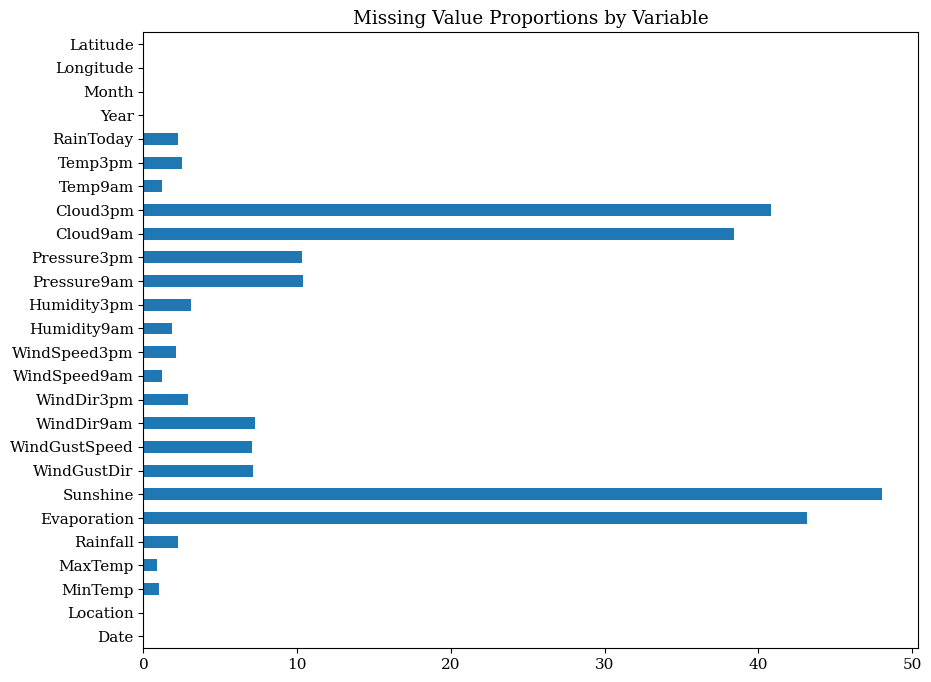

In [36]:
(df.isnull().sum() / df.shape[0] * 100).plot(kind='barh', figsize=(10, 8), title='Missing Value Proportions by Variable')

In [37]:
missingness = df.groupby('Location').apply(lambda x: x.isnull().sum() / len(x) * 100)
missingness.sort_values(by='RainToday', ascending=False, inplace=True)


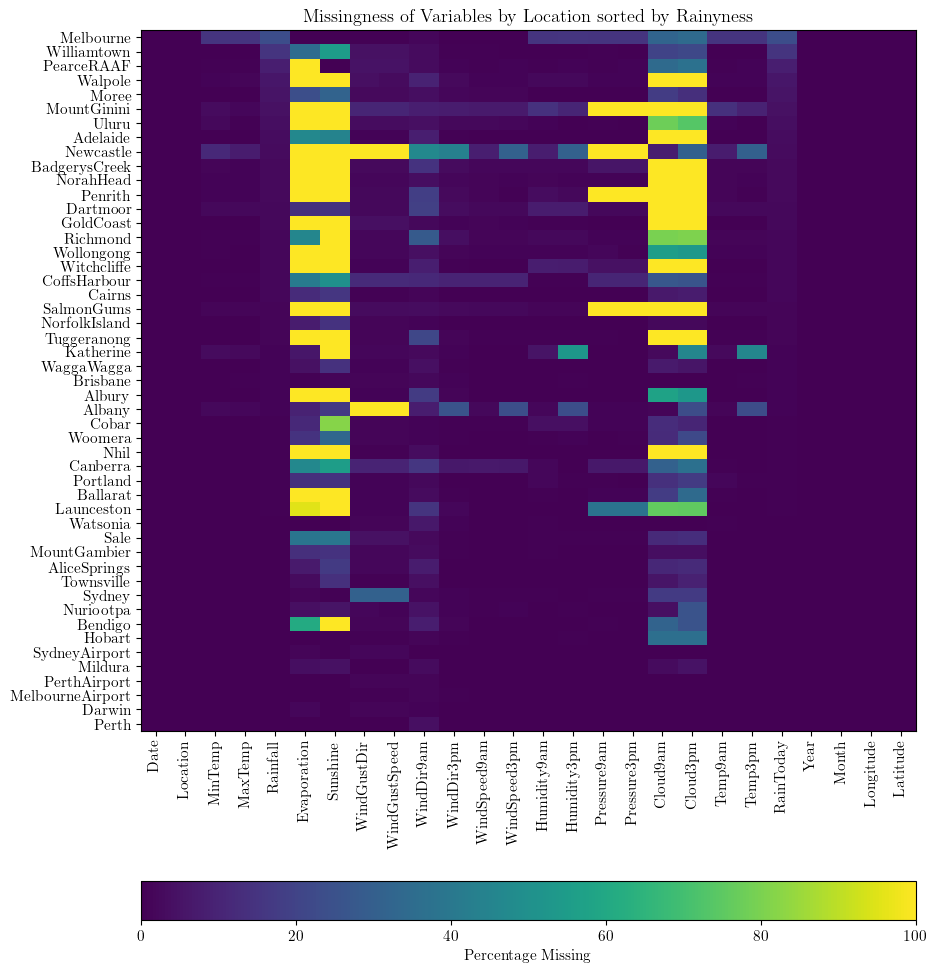

In [38]:
# turn missingness into a heatmap
plt.rcParams.update({'font.size': 11})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 13))
plt.imshow(missingness, aspect='auto', cmap='viridis')
colorbar = plt.colorbar(orientation='horizontal')
colorbar.set_label('Percentage Missing')
plt.yticks(np.arange(len(missingness.index)), missingness.index)
plt.xticks(np.arange(len(missingness.columns)), missingness.columns, rotation=90)
plt.title('Missingness of Variables by Location sorted by Rainyness')
plt.show()

## Missing date sections

Since I'm dealing with time series data and the original data set I found was not intended to be used in a time series fashion, there is a second kind of missingness I checked for. I had to check that the dates are consequtive and the intervals regular.

In [39]:
dataframes = {}
for location in df['Location'].unique():
    dataframes[location] = df[df['Location'] == location]

In [40]:
def check_dates(dataframe):
    """
    Check if the dates in the dataframe are continuous.
    If not, return the missing dates.
	"""
    dates = dataframe['Date'].dt.date
    dates = dates.reset_index(drop=True)
    missing_dates = []
    for i in range(1, len(dates)):
        if dates[i] - dates[i-1] != pd.Timedelta('1 days'):
            missing_dates.append((dates[i-1], dates[i]))
    if len(missing_dates) > 0:
        # print(missing_dates)
        return missing_dates
    return None

In [41]:
missing_dates = {key: check_dates(item) for key, item in dataframes.items()}

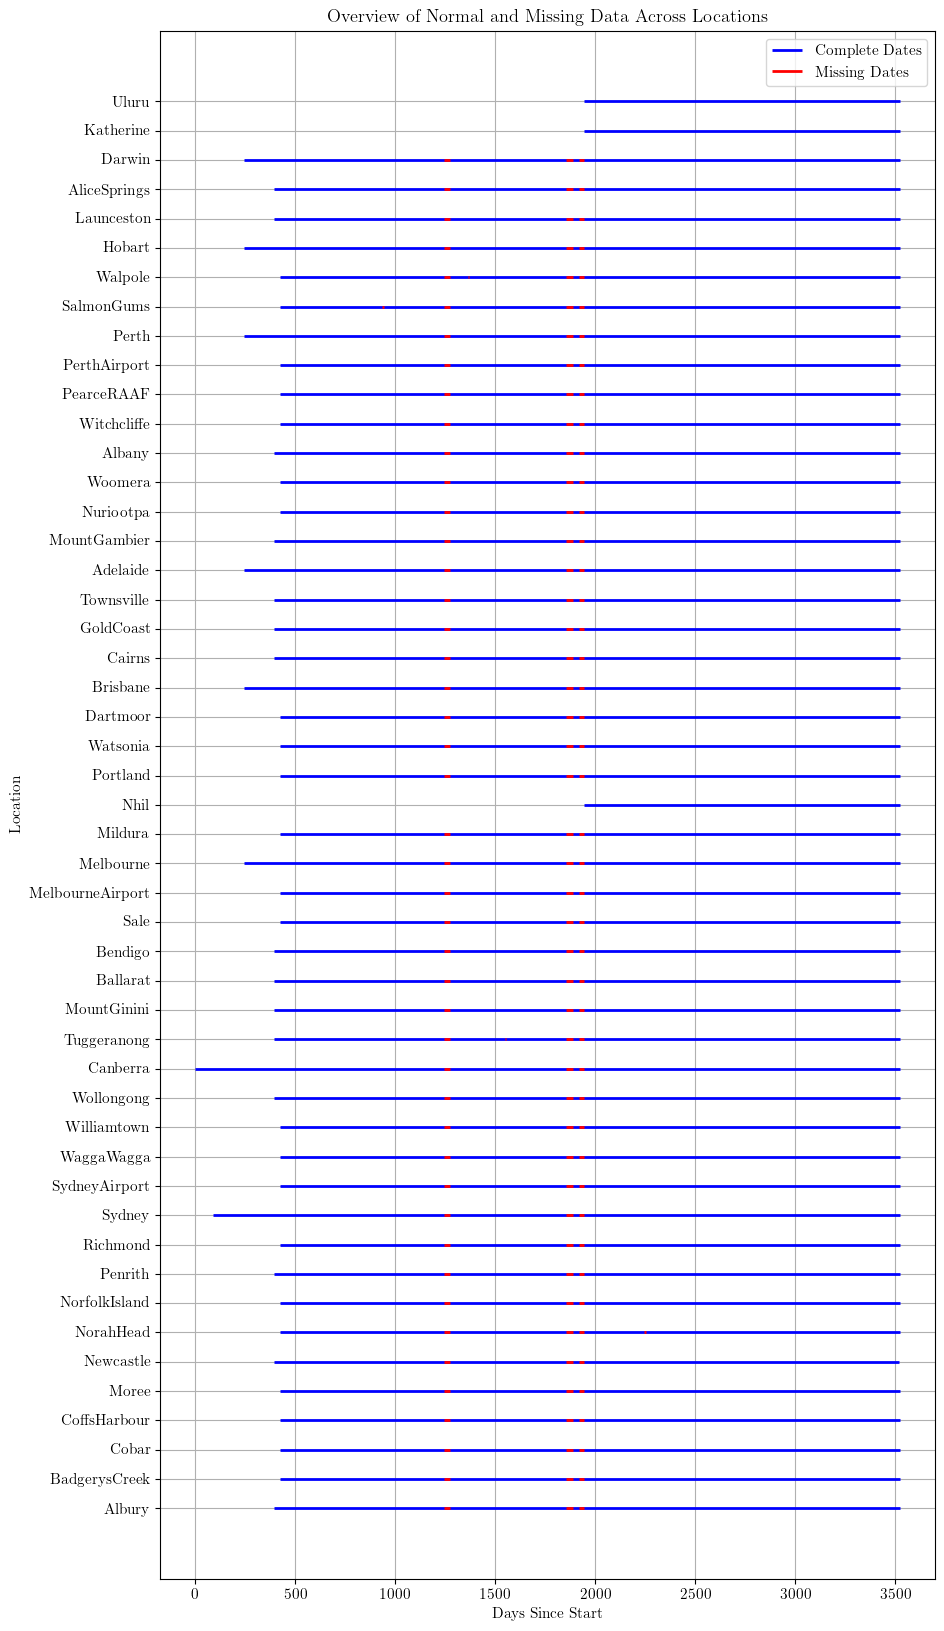

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initialize figure and axis
fig, ax = plt.subplots()

y_value = 0
legend_added = {'Complete Dates': False, 'Missing Dates': False}  # Dictionary to track if legend entries have been added

# Find the global minimum date to start the x-axis from 0
min_date = min(min(data['Date']) for data in dataframes.values())
min_ordinal = pd.Timestamp(min_date).toordinal()

for key, item in dataframes.items():
    data = dataframes[key]
    dates = data['Date'].dt.date
    # Convert dates to the number of days since the minimum date
    dates = np.array(dates.apply(lambda x: pd.Timestamp(x).toordinal())) - min_ordinal

    # Plot complete date ranges as horizontal lines
    if len(dates) > 0:
        label = 'Complete Dates' if not legend_added['Complete Dates'] else ""
        ax.hlines(y=y_value, xmin=np.min(dates), xmax=np.max(dates), colors='blue', linewidth=2, label=label)
        legend_added['Complete Dates'] = True  # Mark the legend as added

    # Plot missing date ranges as red horizontal lines only if there are missing dates
    if missing_dates[key]:
        for start, end in missing_dates[key]:
            start = pd.Timestamp(start).toordinal() - min_ordinal
            end = pd.Timestamp(end).toordinal() - min_ordinal
            label = 'Missing Dates' if not legend_added['Missing Dates'] else ""
            ax.hlines(y=y_value, xmin=start, xmax=end, colors='red', linewidth=2, label=label)
            legend_added['Missing Dates'] = True  # Mark the legend as added

    y_value += 1  # Increment y_value for the next location

# Set x-axis and y-axis titles
ax.set_title('Overview of Normal and Missing Data Across Locations')
ax.set_xlabel('Days Since Start')
ax.set_ylabel('Location')
ax.set_yticks(list(range(len(dataframes))))
ax.set_yticklabels(list(dataframes.keys()))

# Dynamically adjust the figure's height based on the number of locations
fig.set_size_inches(10, 0.5 + 0.4 * len(dataframes))

# Show legend
ax.legend()

# Adding gridlines
ax.grid(True)

plt.show()

Looking at the data split by town we can see that the requiremet of consecutive days is mostly met however not always and care must be taken when configuring the data for training and evaluating the model. 

In [43]:
batches = {}
for key, item in dataframes.items():
    data = dataframes[key]
    dates = data['Date'].dt.date
    dates = dates.reset_index(drop=True)
    batches[key] = []
    batch = []
    for i in range(1, len(dates)):
        if dates[i] - dates[i-1] == pd.Timedelta('1 days'):
            batch.append(dates[i-1])
        else:
            if len(batch) > 100:
                batches[key].append(batch)
            batch = []
    if len(batch) > 100:
        batches[key].append(batch)

In [44]:
for key, item in batches.items():
    ret = ""
    ret += key + " " + str(len(item[0])) + " "
    if (len(item) > 1):
        ret += str(len(item[1])) + " "
    if (len(item) > 2):
        ret += str(len(item[2])) + " "
    if (len(item) > 3):
        ret += str(len(item[3])) + " "
    print(ret)

Albury 850 579 1577 
BadgerysCreek 819 579 1577 
Cobar 819 579 1577 
CoffsHarbour 819 579 1577 
Moree 819 579 1577 
Newcastle 850 579 1576 
NorahHead 819 579 300 1271 
NorfolkIsland 819 579 1577 
Penrith 363 485 579 1577 
Richmond 819 579 1577 
Sydney 1154 579 1577 
SydneyAirport 819 579 1577 
WaggaWagga 819 579 1577 
Williamtown 819 579 1577 
Wollongong 850 579 1577 
Canberra 1246 579 1577 
Tuggeranong 850 274 303 1577 
MountGinini 850 579 1577 
Ballarat 850 579 1577 
Bendigo 850 579 1577 
Sale 819 579 1577 
MelbourneAirport 819 579 1577 
Melbourne 1003 579 1577 
Mildura 819 579 1577 
Nhil 1577 
Portland 819 579 1577 
Watsonia 819 579 1577 
Dartmoor 819 579 1577 
Brisbane 1003 579 1577 
Cairns 850 579 1577 
GoldCoast 850 579 1577 
Townsville 850 579 1577 
Adelaide 1003 579 1577 
MountGambier 850 579 1577 
Nuriootpa 819 579 1577 
Woomera 819 579 1577 
Albany 850 579 1577 
Witchcliffe 819 579 1577 
PearceRAAF 819 579 1577 
PerthAirport 819 579 1577 
Perth 1003 579 1577 
SalmonGums 507 3

# Split data

I tried to keep as much data as possible. For the test and validation set I will use the 2 most recent years (1 for each). The rest of the data will be for training. Note this leaves at least 1 consecutive year for training for each location. I will need to be careful when creating the timeseries batches to insure timeseries integrity.

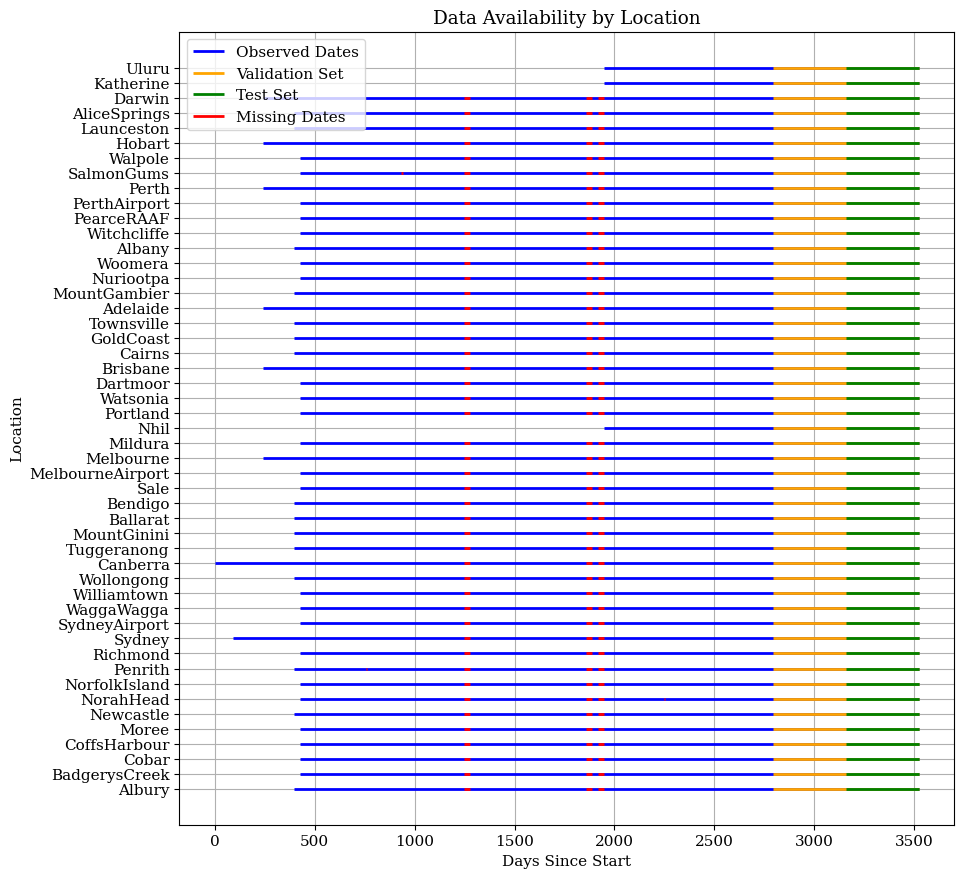

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams.update({'font.size': 11})
plt.rc('text', usetex=False)

# Initialize figure and axis
fig, ax = plt.subplots()

y_value = 0
legend_added = {'Observed Dates': False, 'Missing Dates': False, 'Test Set': False, 'Validation Set': False}  # Updated to include new legend entry

# Find the global minimum date to start the x-axis from 0
min_date = min(min(data['Date']) for data in dataframes.values())
min_ordinal = pd.Timestamp(min_date).toordinal()

for key, item in dataframes.items():
    data = dataframes[key]
    dates = data['Date'].dt.date
    # Convert dates to the number of days since the minimum date
    dates = np.array(dates.apply(lambda x: pd.Timestamp(x).toordinal())) - min_ordinal

    # Plot complete date ranges as horizontal lines
    if len(dates) > 0:
        label = 'Observed Dates' if not legend_added['Observed Dates'] else ""
        ax.hlines(y=y_value, xmin=np.min(dates), xmax=np.max(dates), colors='blue', linewidth=2, label=label)
        legend_added['Observed Dates'] = True  # Mark the legend as added
    
    if len(dates) > 0:
	    last_730_start = max(np.max(dates) - 730, np.min(dates))  # Ensure the start is within the existing data range
	    label = 'Validation Set' if not legend_added['Validation Set'] else ""
	    ax.hlines(y=y_value, xmin=last_730_start, xmax=np.max(dates), colors='orange', linewidth=2, label=label)
	    legend_added['Validation Set'] = True  # Mark the legend as added

    # Highlight the last 365 days in green
    if len(dates) > 0:
        last_365_start = max(np.max(dates) - 365, np.min(dates))  # Ensure the start is within the existing data range
        label = 'Test Set' if not legend_added['Test Set'] else ""
        ax.hlines(y=y_value, xmin=last_365_start, xmax=np.max(dates), colors='green', linewidth=2, label=label)
        legend_added['Test Set'] = True  # Mark the legend as added
        
    # Plot missing date ranges as red horizontal lines only if there are missing dates
    if missing_dates[key]:
        for start, end in missing_dates[key]:
            start = pd.Timestamp(start).toordinal() - min_ordinal
            end = pd.Timestamp(end).toordinal() - min_ordinal
            label = 'Missing Dates' if not legend_added['Missing Dates'] else ""
            ax.hlines(y=y_value, xmin=start, xmax=end, colors='red', linewidth=2, label=label)
            legend_added['Missing Dates'] = True  # Mark the legend as added

    y_value += 1  # Increment y_value for the next location

# Set x-axis and y-axis titles
ax.set_title('Data Availability by Location')
ax.set_xlabel('Days Since Start')
ax.set_ylabel('Location')
ax.set_yticks(list(range(len(dataframes))))
ax.set_yticklabels(list(dataframes.keys()))

# Dynamically adjust the figure's height based on the number of locations
fig.set_size_inches(10, 0.5 + 0.2 * len(dataframes))

# Show legend
ax.legend(loc='upper left')

# Adding gridlines
ax.grid(True)

plt.show()

In [46]:
# split into train and test sets (validation will be done later)
batches = {}
for key, item in dataframes.items():
    data = dataframes[key]
    dates = data['Date'].dt.date
    dates = dates.reset_index(drop=True)
    batches[key] = []
    batch = []
    for i in range(1, len(dates)):
        if dates[i] - dates[i-1] == pd.Timedelta('1 days'):
            batch.append(dates[i-1])
        else:
            batches[key].append(batch)
            batch = []
    batches[key].append(batch)
batches_indices = {k: [] for k in batches.keys()}
for key, item in batches.items():
    batches_indices[key].append([0, len(item[0])+1])
    for i in range(1, len(item)):
        batches_indices[key].append([batches_indices[key][i-1][1], batches_indices[key][i-1][1] + len(item[i])+1])

In [47]:
clean_dataframes = {}
clean_valid_dataframes = {}
clean_test_dataframes = {}
for location, data_ranges in batches_indices.items():
    data = dataframes[location]
    num_ranges = len(data_ranges)
    for i in range(num_ranges):
        start = data_ranges[i][0]
        end = data_ranges[i][1]
        if i == num_ranges-1:
            # remove last 2 * 365 days that is for test and validation
            clean_dataframes[location + str(i)] = data[start:end-365-365]
            clean_valid_dataframes[location] = data[end-365-365:end-365]
            clean_test_dataframes[location] = data[end-365:]
        # get data inbetween these indices
        clean_dataframes[location + str(i)] = data[start:end]
        

In [48]:
missing_dates = {key: check_dates(item) for key, item in clean_dataframes.items()}

In [49]:
from collections import Counter
Counter(missing_dates.values())


Counter({None: 192})

Within batches all date ranges are complete.

## Impute missing values

Since this was not a primary concern of this project I just used simple median and mode imputation for the missing variables.

In [50]:
# impute by median and mode (not by location)
cts_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm']
cat_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# combine all dataframes in train set
train_df = pd.concat(clean_dataframes.values())
# compute medians and modes on train set
medians = {col: np.nanmedian(train_df[col]) for col in cts_columns}
modes = {col: train_df[col].mode()[0] for col in cat_columns + ['RainToday']}

clean_dataframe_simple_imputation = clean_dataframes.copy()
clean_valid_dataframes_simple_imputation = clean_valid_dataframes.copy()
clean_test_dataframes_simple_imputation = clean_test_dataframes.copy()

for key, item in clean_dataframe_simple_imputation.items():
	for col in cts_columns:
		item.loc[item[col].isnull(), col] = medians[col]
	for col in cat_columns + ['RainToday']:
		item.loc[item[col].isnull(), col] = modes[col]
  
for key, item in clean_test_dataframes_simple_imputation.items():
	for col in cts_columns:
		item.loc[item[col].isnull(), col] = medians[col]
	for col in cat_columns + ['RainToday']:
		item.loc[item[col].isnull(), col] = modes[col]
  
for key, item in clean_valid_dataframes_simple_imputation.items():
	for col in cts_columns:
		item.loc[item[col].isnull(), col] = medians[col]
	for col in cat_columns + ['RainToday']:
		item.loc[item[col].isnull(), col] = modes[col]

## Save data

In [51]:
# write to csv
os.makedirs("data/simple_imputation/train", exist_ok=True)
for key, item in clean_dataframe_simple_imputation.items():
	item.to_csv("data/simple_imputation/train/" + key + ".csv", index=False)

In [52]:
os.makedirs("data/simple_imputation/valid", exist_ok=True)
for key, item in clean_valid_dataframes_simple_imputation.items():
	item.to_csv("data/simple_imputation/valid/" + key + ".csv", index=False)

In [53]:
os.makedirs("data/simple_imputation/test", exist_ok=True)
for key, item in clean_test_dataframes_simple_imputation.items():
	item.to_csv("data/simple_imputation/test/" + key + ".csv", index=False)